

Source: 
- https://www.kaggle.com/dgawlik/nyse/downloads/prices-split-adjusted.csv/notebook
- https://zhuanlan.zhihu.com/p/28919765
- https://r2rt.com/recurrent-neural-networks-in-tensorflow-ii.html
- https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

#display parent directory and working directory
print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));

C:\Users\atseng17\Dropbox\python_tutorials\Recurrent_Neural_Networks: ['bitcoin_price_prediction', 'predict_future_sales', 'Shampoo_sales', 'Tensorflow']
C:\Users\atseng17\Dropbox\python_tutorials\Recurrent_Neural_Networks\Tensorflow: ['.ipynb_checkpoints', 'input', 'NY_Stock_Price_Prediction_RNN.ipynb', 'Untitled.ipynb']


In [2]:
# import all stock prices 
df = pd.read_csv("./input/prices-split-adjusted.csv", index_col = 0)
df.info()
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB

number of different stocks:  501
['GIS', 'DPS', 'PRU', 'ILMN', 'ULTA', 'ROP', 'AN', 'ITW', 'SO', 'NFLX']


,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


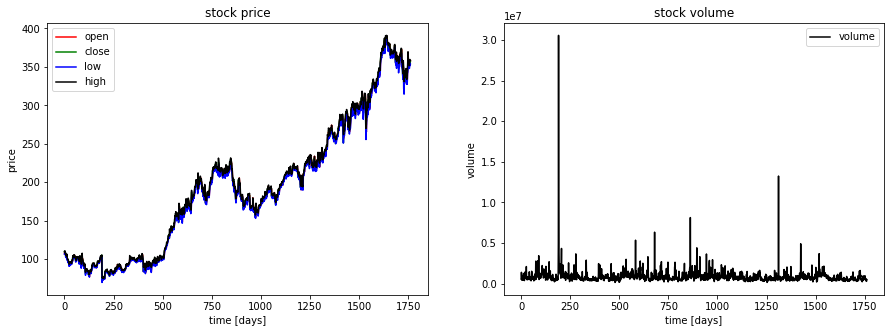

In [3]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [4]:
valid_set_size = int(np.round(valid_set_size_percentage/100*df[df.symbol == 'EQIX'].shape[0]));  
test_set_size = int(np.round(test_set_size_percentage/100*df[df.symbol == 'EQIX'].shape[0]));
train_set_size = df[df.symbol == 'EQIX'].shape[0] - (valid_set_size + test_set_size);

In [5]:
print(train_set_size)

1410


In [6]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
df_stock = df[df.symbol == 'EQIX'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

df_stock.columns.values =  ['open', 'close', 'low', 'high']
x_train.shape =  (1394, 19, 4)
y_train.shape =  (1394, 4)
x_valid.shape =  (174, 19, 4)
y_valid.shape =  (174, 4)
x_test.shape =  (174, 19, 4)
y_test.shape =  (174, 4)


C:\Users\atseng17\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


How does the input look like?


$$ \begin{bmatrix} \begin{bmatrix} 
[O_0&C_0&L_0&H_0]\\
[O_1&C_1&L_1&H_1]\\
\vdots&\vdots&\vdots&\vdots\\
[O_{18}&C_{18}&L_{18}&H_{18}]\\
\end{bmatrix} ,
\begin{bmatrix} 
[O_1&C_1&L_1&H_1]\\
[O_2&C_2&L_2&H_2]\\
\vdots&\vdots&\vdots&\vdots\\
[O_{19}&C_{19}&L_{19}&H_{19}]\\
\end{bmatrix},
...,
\begin{bmatrix} 
[O_{1393}&C_{1393}&L_{1393}&H_{1393}]\\
[O_{1394}&C_{1394}&L_{1394}&H_{1394}]\\
\vdots&\vdots&\vdots&\vdots\\
[O_{1411}&C_{1411}&L_{1411}&H_{1411}]\\
\end{bmatrix}\end{bmatrix} $$

Before Batching in the next step, our input to the batch function has the dimensionallity is ((train_size-window)/moving_step+1,19,4) or (1393,19,4)

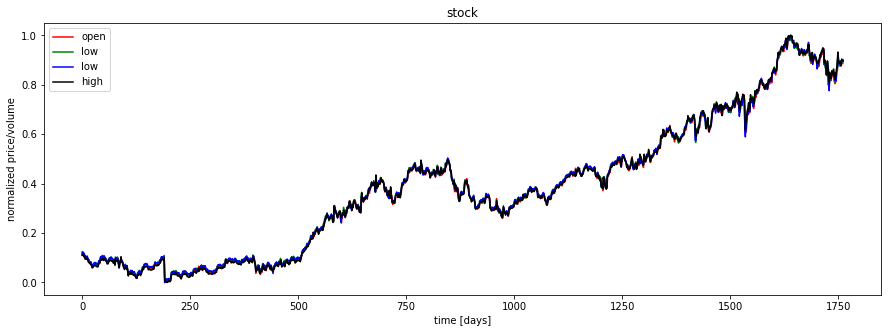

In [7]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()


$$ perm array=[0,1,2,3,4,5,6,7,8,9,10,11,12,13] $$

after shuffling...

$$ permarray=[11,3,8,9,6,13,4,10,1,12,2,5,0,7] $$

$$ index  in  epoch=0 $$ 

$$ start=0 $$ 

$$ index  in epoch=0+3=3 $$ 

$$ batch_1=[11,3,8] $$ 

$$ start=3 $$ 

$$ index  in  epoch=3+3=6 $$ 

$$ batch_2=[9,6,13] $$ 

$$ start=6 $$ 

$$ index  in  epoch=6+3=9 $$ 

$$ batch_3=[4,10,1] $$ 

$$ start=9 $$ 

$$ index  in  epoch=9+3=12 $$ 

$$ batch_4=[12,2,5] $$ 

$$ start=12 $$ 

$$ index  in  epoch=12+3=15 $$ 

but 15> train size=14

shuffle perm_array...

$$ permarray=[8,3,4,9,1,10,5,2,6,11,13,2,7,12] $$

$$ start=0 $$ 

$$ index  in  epoch=0+3=3 $$ 

$$ batch_5=[8,3,4] $$ 



Now let's see our case...



$$ permarray=[0,1,2,...,1394]$$ 

after suffling...

$$ permarray=[339,12,76,...,818]$$ 

what a single batch looks like...

$$ \begin{bmatrix}
[[*,*,*,*]_{339},[*,*,*,*]_{12},[*,*,*,*]_{76},...]\\ 
\vdots\\
\end{bmatrix}_{(50,20,4)}$$ 

In [8]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
#reshape rnn_outputs and y so we can get the logits in a single matmul
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):#train_set_size/batch_size is the iteration in each epoch
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:# record loss every 5 epoches 
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.


InternalError: cudaGetDevice() failed. Status: CUDA driver version is insufficient for CUDA runtime version